## Mutual Web Outlinks Example

**RBTODO** example. Summary -- joblib is not great at this because it is not embarassingly parallel.

JOBLIB and global variables.

Let's start with a small graph to see how this works.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

G = nx.erdos_renyi_graph(5, 0.8, seed=None, directed=True)

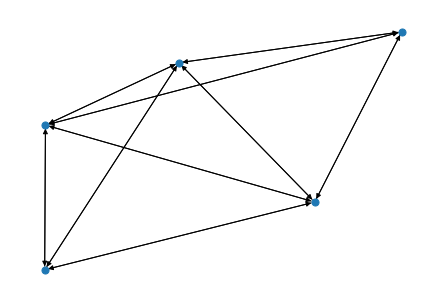

In [3]:
nx.draw(G, pos=nx.spring_layout(G), ax=None, node_size=50)

Compute the shared outlinks, which are the dot product of all combinations of rows.  We only populate the upper R because that's all combinations.

In [4]:
gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
outmat

array([[0., 3., 2., 2., 3.],
       [0., 0., 2., 2., 3.],
       [0., 0., 0., 3., 2.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0.]])

Getting this code right is very touchy. You have to take the dot product of _arrays_ not matrixes.

Now generate a big graph and we'll start our performance analysis. Let's look at a serial version on a graph with 1000 nodes and about 5 outbound edges per node. 

Serial program to calculate mutual outlinks.

In [2]:
# cycles disappear when p = log(n)/n
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)
G.number_of_edges()

NetworkXError: random_state_index is incorrect

In [5]:
import numpy as np

gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
        
np.count_nonzero(outmat)

46889

In [6]:
%%timeit

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

5.18 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So, now we have a serial implementation. Let's parallelize it.  It is always easiest to parallelize the outer loop.

In [7]:
%%timeit

def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
#print(f"gmat {gmat}")
#print(f"outmat {outmat}")
#np.count_nonzero(outmat)

3.32 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Does it help to flatten the loop?
Note this only populates the upper-R above the diagonal.

In [8]:
%%timeit

def row_and_row (i,j):
  return np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

itertuples = list()

def gen_ij():
    for i in range(gmat.shape[0]):
        for j in range(i+1,gmat.shape[1]):
            yield (i,j)
    return

#for i in range(gmat.shape[0]):
#    for j in range(i+1,gmat.shape[1]):
#        itertuples.append((i,j))
                
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(row_and_row)(i,j) for (i,j) in gen_ij())

outmat = np.array(partials)
#np.count_nonzero(outmat)
#outmat

4.78 s ± 714 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So the big problem here is data copying. `gmat` is used in parallel contexts and must be copied to each process. Let's try a shared-memory approach, c.f. lecture on GIL and python shared-memory parallelism.  Let's go back to the simple version of the inner/outer nested loops.

In [9]:
#small graph for testing
#G = nx.erdos_renyi_graph(5,0.8,directed=True)
#Big graph for eval
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
gmat = nx.to_numpy_matrix(G)
outmat = np.zeros(gmat.shape)

In [10]:
%%timeit

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

#print(outmat)
np.count_nonzero(outmat)

5.5 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Compile the inner loop and see the effects.

In [11]:
%%timeit

from numba import jit

outmat = np.zeros(gmat.shape)

@jit(nopython=True)
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
   # print(partial_out)
    return partial_out
    
for i in range(gmat.shape[0]):
    outmat[i,:] = inner_loop(i)

#print(outmat)
np.count_nonzero(outmat)

275 ms ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


and parallelize the outer loop

In [12]:
%%timeit

from numba import jit, prange

@jit(nopython=True)
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
   # print(partial_out)
    return partial_out

# Gotta be in a function to parallize
@jit(nopython=True)    
def outerloop():
    outmat = np.zeros(gmat.shape)

    for i in prange(gmat.shape[0]):
        outmat[i,:] = inner_loop(i)

    #print(outmat)
    np.count_nonzero(outmat)

101 µs ± 4.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<AxesSubplot:>

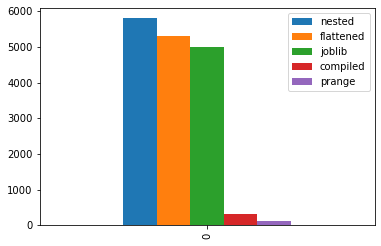

In [13]:
import pandas as pd

# RBTODO get values from code
d = { 'nested': [5800], 'flattened': [5310], 'joblib': [5000], 'compiled': [319], 'prange': [114] }

df = pd.DataFrame (data=d)
df.head()
df.plot.bar()

From here, we should do a study of the parameters of 

*Q1* Loops.  NUmba documentation says

```Whilst NumPy has developed a strong idiom around the use of vector operations, 
Numba is perfectly happy with loops too. For users familiar with C or Fortran, 
writing Python in this style will work fine in Numba (after all, LLVM gets a lot 
of use in compiling C lineage languages). For example:```

In [15]:
from numba import njit

@njit(parallel=False)
def ident_np(x):
    return np.cos(x) ** 2 + np.sin(x) ** 2

@njit(parallel=False)
def ident_loops(x):
    r = np.empty_like(x)
    n = len(x)
    for i in range(n):
        r[i] = np.cos(x[i]) ** 2 + np.sin(x[i]) ** 2
    return r

a = np.random.rand(100000,1)

%timeit ident_np(a)
%timeit ident_loops(a)


1.85 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.86 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Hmmm. That seems not to be true. Probably a function of vectorization or potentially parallelization inside np.